# National Intertidal Digital Elevation Model (NIDEM)

**What does this notebook do?** This notebook uses the ITEM 2.0 product to compute continuous elevation data for Australia's intertidal zone. It initially imports ITEM REL files and median tidal elevations for each tidal interval, computes elevations at interval boundaries, extracts contours around each tidal interval, and then interpolates between these contours using TIN/Delaunay triangulation linear interpolation. This interpolation method preserves the tidal interval boundaries of ITEM 2.0. The notebook exports the contours used for interpolation as line shapefiles and the resulting DEM as a geotiff, and finally performs a simple validation using RTK GPS data.

**Date:** April 2018

**Author:** Robbi Bishop-Taylor

## Load modules and define functions

In [20]:
# Import libraries
import sys
import os
import glob
import fiona
import itertools
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import statsmodels.formula.api as sm
from collections import OrderedDict
from shapely.geometry import Point, LineString, MultiLineString, mapping
from fiona.crs import from_epsg
from osgeo import gdal
from scipy.interpolate import griddata
from scipy import ndimage as nd
from scipy import stats
from skimage import measure
from matplotlib import pyplot as plt
from IPython.display import display


# Import DEA Notebooks scripts
sys.path.append(os.path.abspath('/g/data/r78/rt1527/dea-notebooks/algorithms'))
import SpatialTools 

"""
TODO: Investigate scipy.interpolate.RectBivariateSpline, scipy.interpolate.interp2d,
spipy.interpolate.RegularGridInterpolator, sklearn.gaussian_process.GaussianProcess
"""

def fill(data, invalid=None):
    """
    Replace value of invalid cells by the value of the nearest 
    cell with valid data

    :attr data: numpy array of any dimension
    :attr invalid: a binary array of same shape as 'data'. Data value 
                   are replaced where invalid is True. Defaults to 
                   np.isnan(data) if no layer is given

    :returns: Array with invalid values filled with nearest valid data value
    """    
    
    # If no invalid array is given, default to setting invalid based on nan
    if invalid is None:
        
        invalid = np.isnan(data)

    ind = nd.distance_transform_edt(invalid, 
                                    return_distances=False, 
                                    return_indices=True)
    
    return data[tuple(ind)]


def plot_kde(x_vals, y_vals, nbins=300, y_lims=(-6, 3), x_lims=(-6, 3), power=1.0):

    # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
    k = stats.kde.gaussian_kde([x_vals, y_vals])
    xi, yi = np.mgrid[y_lims[0]:y_lims[1]:nbins*1j, x_lims[0]:x_lims[1]:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    zi = np.power(zi, power)    

    # Plot output x-y scatter plot
    fig, ax = plt.subplots(figsize = (12, 12))
    ax.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap = "magma")
    ax.set_ylim(y_lims[0], y_lims[1])
    ax.set_xlim(x_lims[0], x_lims[1])

    
def reproject_to_template(input_raster, template_raster, output_raster, resolution=None,
                         resampling=gdal.GRA_Average, nodata_val=0):
    
    """
    Reprojects a raster to the extent, cell size, projection and dimensions of a template 
    raster using GDAL. Optionally, can set custom resolution for output reprojected raster
    using 'resolution'; this will affect raster dimensions/width/columns.
    
    Last modified: April 2018
    Author: Robbi Bishop-Taylor    
    
    :attr input_raster: path to input geotiff raster to be reprojected (.tif)
    :attr template_raster: path to template geotiff raster (.tif) used to copy extent, projection etc
    :attr output_raster: output reprojected raster path with geotiff extension (.tif)
    :attr resolution: optionally set custom cell size for output reprojected raster; defaults to 
                      'None', or the cell size of template raster 
    :attr resampling: GDAL resampling method to use for reprojection; defaults to gdal.GRA_Average 
    :attr nodata_val: values in the output reprojected raster to set to nodata; defaults to 0
    """
    
    # Import raster to reproject
    print("Importing raster datasets")
    input_ds = gdal.Open(input_raster)
    input_proj = input_ds.GetProjection()
    input_geotrans = input_ds.GetGeoTransform()
    data_type = input_ds.GetRasterBand(1).DataType
    n_bands = input_ds.RasterCount  
    
    # Import raster to use as template
    template_ds = gdal.Open(template_raster)   
    template_proj = template_ds.GetProjection()
    template_geotrans = template_ds.GetGeoTransform()
    template_w = template_ds.RasterXSize
    template_h = template_ds.RasterYSize
    
    # Use custom resolution if supplied
    if resolution:
        
        template_geotrans[1] = float(resolution)
        template_geotrans[-1] = -float(resolution)

    # Create new output dataset to reproject into
    output_ds = gdal.GetDriverByName('Gtiff').Create(output_raster, template_w, 
                                                     template_h, n_bands, data_type)  
    output_ds.SetGeoTransform(template_geotrans)
    output_ds.SetProjection(template_proj)
    output_ds.GetRasterBand(1).SetNoDataValue(nodata_val)

    # Reproject raster into output dataset
    print("Reprojecting raster")
    gdal.ReprojectImage(input_ds, output_ds, input_proj, template_proj, resampling)
    
    # Close datasets
    input_ds = None
    output_ds = None
    template_ds = None    
    
    print("Reprojected raster exported to {}".format(output_raster))


## Set up analysis
Set up path to data and polygon to process. `plotting_subset` does not affect the analysis, but can be used to provide more useful zoomed-in plots.

In [607]:
# Working directory
os.chdir("/g/data/r78/rt1527/nidem")

# Path to ITEM offset product
item_offset_path = "/g/data2/v10/ITEM/offset_products"
item_relative_path = "/g/data2/v10/ITEM/rel_products"
item_conf_path = "/g/data2/v10/ITEM/conf_products"

# Set ITEM polygon for analysis
polygon_ID = 252

# Zoom-in for plots (has no effect on analysis but allows you to plot a zoomed-in subset)
plotting_subset = np.index_exp[:, :]
plotting_subset = np.index_exp[2000: 2400, 1500:1750]

# Print run details
print("Processing polygon {0} from {1}".format(polygon_ID, item_offset_path))

Processing polygon 252 from /g/data2/v10/ITEM/offset_products


## ITEM interval boundary value extraction
ITEM offset values represent the median tidal height for each tidal interval ([Sagar et al. 2015](https://doi.org/10.1016/j.rse.2017.04.009)). Because ITEM tidal intervals are linearly spaced by design, this code uses a simple linear model to compute new offset values for each interval boundary (e.g. the boundary between ITEM interval 1 and 2). This allows us to assign a more appropriate tidal height to the contours that divide the ITEM tidal intervals than would be possible through simply assigning median tidal heights to the downhill or uphill contours. 

,offset
item_interval,
1,-2296
2,-1709
3,-1142
4,-449
5,135
6,824
7,1387
8,2036
9,2669


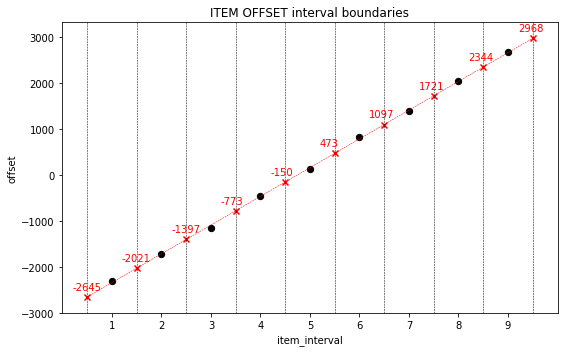

In [608]:
# Import ITEM offset values for each ITEM tidal interval
item_offsets = np.loadtxt("{}/elevation.txt".format(item_offset_path), delimiter = ",", dtype = "str")
item_offsets = {int(key):[int(val) for val in value.split(" ")] for (key, value) in item_offsets}
interval_offsets = item_offsets[polygon_ID]

# Create dataframe of offset values by ITEM interval
interval_offsets_df = pd.DataFrame({"item_interval": range(1,10), "offset": interval_offsets})
display(interval_offsets_df.set_index("item_interval"))

# Compute linear model and calculate ITEM offsets at the boundary of each ITEM interval 
# (ensures that extracted contours are placed precisely on the boundary of ITEM intervals)
m, b = np.polyfit(interval_offsets_df["item_interval"], interval_offsets_df["offset"], 1)
interval_boundaries = np.arange(0.5, 10.5, 1.0)
contour_offsets = (m * interval_boundaries + b).astype(int)

# Compute ITEM offset interval used to fill lowest class of ITEM relative layer 
# (not used for interpolation, but ensures lowest contour is placed exactly on interval boundary)
interval_zero = (m * 0 + b).astype(int)

# Plot output
fig, ax = plt.subplots(figsize = (8, 5))
interval_offsets_df.plot(kind = "scatter", x = "item_interval", y = "offset", s = 40, 
                         color = "black", xticks=interval_offsets_df['item_interval'], ax = ax)
ax.scatter(interval_boundaries, contour_offsets, color = 'red', marker = "x")
ax.plot(interval_boundaries, contour_offsets, color = 'red', linestyle = '--', lw = 0.5)
for xc in interval_boundaries:
    plt.axvline(x = xc, color = 'k', linestyle = '--', lw = 0.5)
for i, txt in enumerate(contour_offsets):
    ax.annotate(txt, (interval_boundaries[i] - 0.3, contour_offsets[i] + 150), color = "red")
plt.title("ITEM OFFSET interval boundaries")
plt.tight_layout()


## Import and prepare ITEM offset raster
Imports ITEM REL raster for given polygon, and use a lookup index array of offset values to classify into a new array of evenly-spaced ITEM offset values (in *mm* units relative to sea level) suitable for contour extraction. 

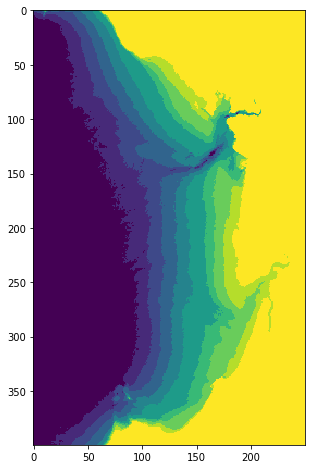

In [609]:
# Import raster and extract shape, projection info and geotransform data
item_filename = glob.glob("{}/ITEM_REL_{}_*.tif".format(item_relative_path, polygon_ID))[0]
item_ds = gdal.Open(item_filename)
item_array = item_ds.GetRasterBand(1).ReadAsArray() 
yrows, xcols = item_array.shape
prj = item_ds.GetProjection()
geotrans = item_ds.GetGeoTransform()
upleft_x, x_size, x_rotation, upleft_y, y_rotation, y_size = geotrans

# Temporarily assign nodata -6666 values to new class 10 prior to lookup classification
item_array[item_array == -6666] = 10
 
# Create lookup index array, and index by ITEM relative layer to classify into offset values
# (this method should be resilient to ITEM layers with fewer than 9 classes)
test_lut = np.array([interval_zero] + interval_offsets + [np.nan])
offset_array = test_lut[item_array]

# Dilate data area of array by two pixels to eliminate NA contours on tile edges
# (this only affects pixels directly on the boundary of two polygon arrays)
dilated_array = nd.morphology.binary_dilation(~np.isnan(offset_array),  iterations = 2)
offset_array = fill(offset_array)
offset_array[~dilated_array] = np.nan

# Plot original data
plt.figure(figsize = (8, 8))
plt.imshow(offset_array[plotting_subset])  
plt.show()


## Extract contours
Uses `scikit.measure.find_contours` to rapidly extract contour boundaries between ITEM tidal intervals, and assigns these contours with previously calculated elevation values. Contours are exported as line shapefiles to assist in subsequent assessment of output DEMs.

In [610]:
# Output dict to hold contours for each offset
contour_dict = OrderedDict()

try:
    for contour_offset in contour_offsets:

        # Extract contours from array
        contours = measure.find_contours(offset_array, contour_offset)      
        print("Extracting contour {}".format(contour_offset))
        
        # Iterate through each contour feature, remove NAs and fix coordinates
        contour_list = list()
        for contour in contours:

            # Convert index coordinates to spatial coordinates in-place
            contour[:, 0] = contour[:, 0] * float(y_size) + upleft_y + (float(y_size) / 2)
            contour[:, 1] = contour[:, 1] * float(x_size) + upleft_x + (float(x_size) / 2)        
            contour = np.insert(contour, 2, contour_offset, axis = 1)

            # Remove contour points with NAs
            contour = contour[~np.isnan(contour).any(axis=1)] 
            contour_list.append(contour)

        # Add list of contour arrays to dict 
        contour_dict[contour_offset] = contour_list
except:
    print("fail")

    
# Export contours to line shapefile to assist in evaluating DEMs
schema = {'geometry':  'MultiLineString', 
          'properties': { 'elevation': 'int' } }      

with fiona.open("output_data/contour/NIDEM_contours_{}.shp".format(polygon_ID), "w", 
                crs = from_epsg(3577),
                driver = "ESRI Shapefile", 
                schema = schema) as output:
    
    for elevation_value, contour_list in contour_dict.items():
        
        # Filter out contours with less than two points (i.e. non-lines)
        contour_list = [x for x in contour_list if len(x) > 1]
        
        # Create multiline string by first flipping coordinates then creating list of linestrings
        contour_linestrings = [LineString([(x, y) for (y, x, z) in contour_array]) 
                               for contour_array in contour_list]
        contour_multilinestring = MultiLineString(contour_linestrings)

        # Write output shapefile to file with elevation field        
        output.write({'properties': { 'elevation': int(elevation_value) },
                      'geometry': mapping(contour_multilinestring) })
        
# Chain and concatenate all arrays nested within array lists (i.e. individual collections of same 
# elevation contours) and dictionary entries (i.e. collections of all same-elevation contours)
all_contours = np.concatenate(list(itertools.chain.from_iterable(contour_dict.values())))
points = all_contours[:, 0:2]
values = all_contours[:, 2]


Extracting contour -2645
Extracting contour -2021
Extracting contour -1397
Extracting contour -773
Extracting contour -150
Extracting contour 473
Extracting contour 1097
Extracting contour 1721
Extracting contour 2344
Extracting contour 2968


## Interpolate contours using TIN/Delaunay triangulation interpolation
Exports a DEM by interpolating previously extracted contours. This uses the linear method from `scipy.interpolate.griddata`, which computes a TIN/Delaunay triangulation of the input data using Qhull before performing linear barycentric interpolation on each triangle.

In [611]:
# Extract bounds of ITEM layer
minx = upleft_x
maxx = upleft_x + (x_size * xcols)
miny = upleft_y + (y_size * yrows)
maxy = upleft_y

# Create interpolation grid (from, to, by values in metre units)
grid_y, grid_x = np.mgrid[maxy:miny:1j * yrows,
                          minx:maxx:1j * xcols]

# Interpolate between points onto grid. This uses the 'linear' method from 
# scipy.interpolate.griddata, which computes a TIN/Delaunay triangulation of the input 
# data with Qhull and performs linear barycentric interpolation on each triangle
print("Interpolating data for polygon {}".format(polygon_ID))
interpolated_array = griddata(points, values, (grid_y, grid_x), method = "linear")


Interpolating data for polygon 252


## Mask interpolated array to keep only good data
Masks the interpolated array to remove areas with nodata, and the lowest and highest elevation intervals from the original ITEM layer (lowest and highest intervals cannot be correctly interpolated as they have no lower or upper bounds). In addition, masks out areas with high ITEM confidence NDWI standard deviation (i.e. areas where inundation patterns are not driven by tidal influences), as elevation offset values in these areas are likely to be invalid.

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


Masking data for polygon 252


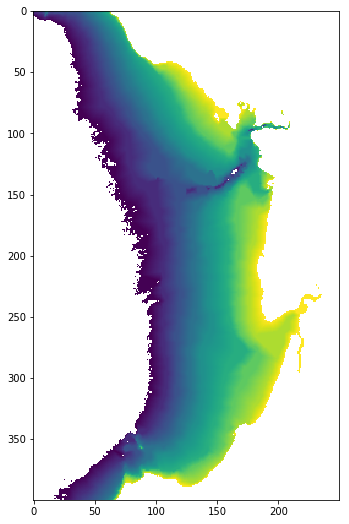

Exporting DEM for polygon 252


In [612]:
# Import ITEM confidence NDWI standard deviation array for polygon
conf_filename = glob.glob("{}/ITEM_STD_{}_*.tif".format(item_conf_path, polygon_ID))[0]
conf_ds = gdal.Open(conf_filename)
conf_array = conf_ds.GetRasterBand(1).ReadAsArray() 

# Create mask flagging nodata values (== 1), lowest ITEM interval (2), highest ITEM 
# interval (3), and ITEM confidence NDWI standard deviation greater than 0.25 (4)
baddata_mask = np.full(item_array.shape, np.nan)
baddata_mask[item_array == 10] = 1  # areas with nodata in original ITEM layer
baddata_mask[item_array == 0] = 2  # areas in lowest ITEM interval
baddata_mask[item_array == 9] = 3  # areas in highest ITEM interval
baddata_mask[conf_array > 0.25] = 4  # areas with > 0.25 ITEM confidence NDWI STD

# Mask DEM to keep only data with no bad data flags
print("Masking data for polygon {}".format(polygon_ID))
interpolated_array[~np.isnan(baddata_mask)] = np.nan

# Plot output interpolated and masked DEM
plt.figure(figsize = (9, 9))
plt.imshow(interpolated_array[plotting_subset])
plt.show()

# Export resulting DEM as a geotiff
print("Exporting DEM for polygon {}".format(polygon_ID))
SpatialTools.array_to_geotiff(fname = "output_data/dem/NIDEM_dem_{}.tif".format(polygon_ID), 
                              data = interpolated_array, 
                              geo_transform = geotrans, 
                              projection = prj, 
                              nodata_val = np.nan)

# Export mask to geotiff
SpatialTools.array_to_geotiff(fname = "output_data/mask/NIDEM_mask_{}.tif".format(polygon_ID), 
                              data = baddata_mask, 
                              geo_transform = geotrans, 
                              projection = prj, 
                              nodata_val = np.nan,
                              dtype=gdal.GDT_Byte)

# Close files
conf_ds = None
item_ds = None


## Validation
Test the resulting DEM by comparing against RTK GPS field-recorded data. Because validation data only exists for polygon 33 (Darwin), this imports DEM data for polygon 33 if another polygon is being analysed.

Importing NIDEM_dem_33.tif from file


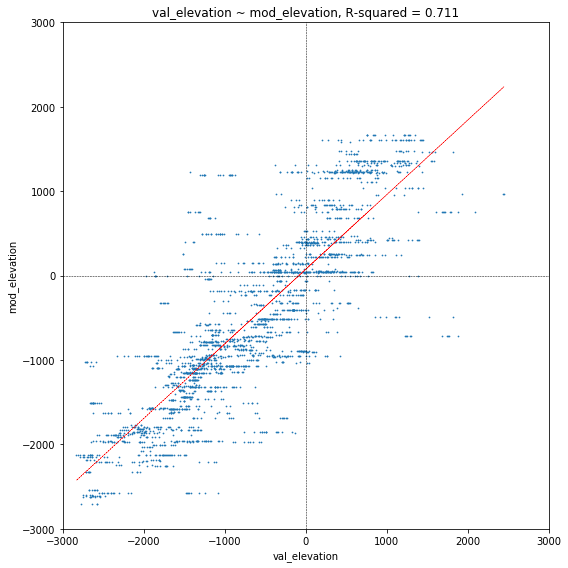

In [613]:
# Because validation data only exists for polygon 33, use this data to compare to validation values
if polygon_ID != 33:
    
    # Import polygon 33 from file
    print("Importing NIDEM_dem_33.tif from file")
    poly33_ds = gdal.Open(glob.glob("output_data/dem/NIDEM_dem_33.tif")[0])
    interpolated_array = poly33_ds.GetRasterBand(1).ReadAsArray() 
    
    # Get projection
    geotrans = poly33_ds.GetGeoTransform()
    upleft_x, x_size, x_rotation, upleft_y, y_rotation, y_size = geotrans  
    

# Open validation point shapefile and use to extract data from underlying array
with fiona.open('raw_data/validation/EastPointonlyRTK_albers.shp') as points:

    point_output = list()

    for n, point in enumerate(points):

        # Extract data from shapefile points; fix units by multiplying by 1000
        x, y = point["geometry"]["coordinates"]
        val_elev = point["properties"]["field_4"] * 1000.0

        # Convert geographic coordinates into index coordinates
        x_ind = int((x - upleft_x) / x_size) # x pixel
        y_ind = int((y - upleft_y) / y_size) # y pixel 

        # Extract modelled elevation from DEM array
        mod_elev = interpolated_array[y_ind, x_ind]

        # Append to list
        point_output.append([x, y, val_elev, mod_elev])

# Combine into dataframe    
colnames = ["x", "y", "val_elevation", "mod_elevation"]
modval_elev = pd.DataFrame(point_output, columns = colnames).dropna() 
modval_elev = modval_elev[modval_elev['val_elevation'] < 2500]

# Compute linear model
m, b = np.polyfit(modval_elev["val_elevation"], modval_elev["mod_elevation"], 1)
modval_rsquared = sm.ols(formula = "val_elevation~mod_elevation", data = modval_elev).fit().rsquared

# Plot output x-y scatter plot
fig, ax = plt.subplots(figsize = (8, 8))
modval_elev.plot(x = "val_elevation", 
                 y = "mod_elevation", 
                 kind = "scatter", 
                 s = 0.5, ax = ax)
ax.plot(modval_elev["val_elevation"], m * modval_elev["val_elevation"] + b, 
        color = 'red', linestyle = '--', lw = 0.5)
plt.axvline(x = 0, color = 'k', linestyle = '--', lw = 0.5)
plt.axhline(y = 0, color = 'k', linestyle = '--', lw = 0.5)
ax.set_ylim(-3000, 3000)
ax.set_xlim(-3000, 3000)
plt.title("val_elevation ~ mod_elevation, R-squared = {}".format(np.round(modval_rsquared, 3)))
plt.tight_layout()


## Lidar validation

,elevation,nidem
elevation,1.000000,0.874089
nidem,0.874089,1.000000


,elevation,nidem
elevation,1.000000,0.928528
nidem,0.928528,1.000000


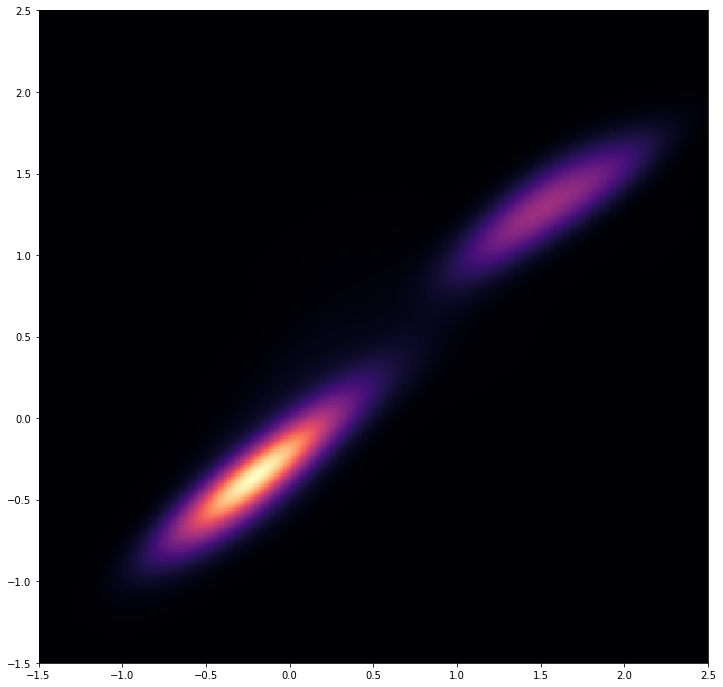

In [26]:
from pyproj import Proj, transform
from scipy.stats import kde

study_area_dict = {'Gladstone': 269, 'Whitsunday': 48}  

out_list = list()

for key, value in study_area_dict.items():
    
    # Import Intertidal DEM data
    nidem_ds = gdal.Open(glob.glob("output_data/dem/NIDEM_dem_{}.tif".format(value))[0])
    nidem_array = nidem_ds.GetRasterBand(1).ReadAsArray() 
    
    # Import data
    points_df = pd.read_csv('output_data/validation/output_points_{}.csv'.format(key))
    points_df = points_df.sample(n = 5000) 

    # Convert lat-lon to X and Y Australian Albers coords
    x, y = transform(p1=Proj(init='EPSG:4326'), p2=Proj(init="EPSG:3577"),
                     x=points_df['point_lon'].values, y=points_df['point_lat'].values)
    val_df = pd.DataFrame({'elevation': points_df.point_z})

    # Now back to new indexes
    x_ind, y_ind = SpatialTools.coords_to_indices(x_coords=x, y_coords=y,
                                     input_raster="output_data/dem/NIDEM_dem_{}.tif".format(value))   

    # Extract values
    val_df['nidem'] = nidem_array[y_ind, x_ind] / 1000.0
    out_list.append(val_df)

# Combine outputs
val_df = pd.concat(out_list)  
val_df = val_df.dropna()

# Correlations
display(val_df.corr(method='pearson'))
display(val_df.corr(method='spearman'))

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
# Plot KDE heatmap
plot_kde(x_vals=val_df["elevation"], 
         y_vals=val_df["nidem"], 
         x_lims=(-1.5, 2.5), y_lims=(-1.5, 2.5), power=1.0)


## Multibeam validation - correlations

,multibeam_elev,nidem_elev
multibeam_elev,1.000000,0.305927
nidem_elev,0.305927,1.000000


,multibeam_elev,nidem_elev
multibeam_elev,1.000000,0.744649
nidem_elev,0.744649,1.000000


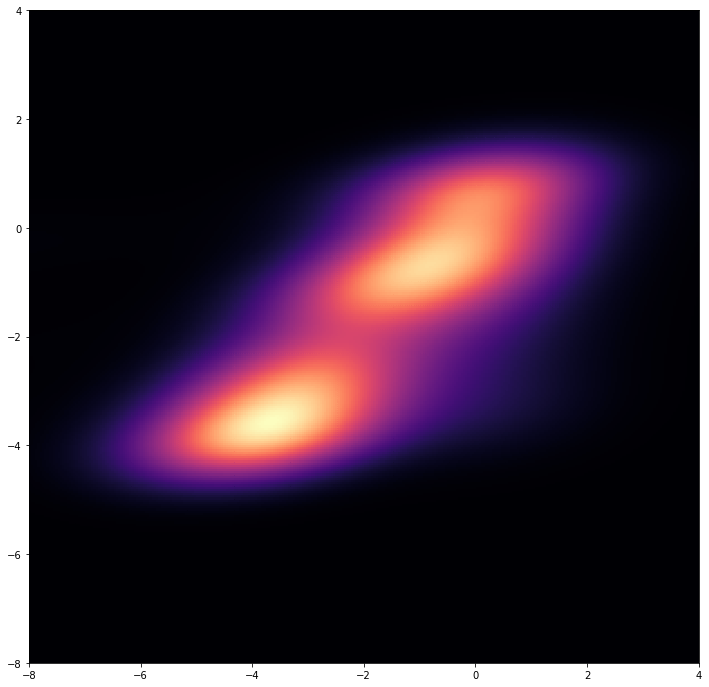

In [12]:
multibeam_paths = glob.glob("/g/data/r78/rt1527/nidem/raw_data/validation/WAMSI_KimberlyReefs/*.tif")

# Merge NIDEM polygons with gdal_merge
os.system('gdal_merge.py -n 0 -a_nodata 0 -o /g/data/r78/rt1527/nidem/nidem_merged.tif ' \
          '/g/data/r78/rt1527/nidem/output_data/dem/NIDEM_dem_78.tif ' \
          '/g/data/r78/rt1527/nidem/output_data/dem/NIDEM_dem_139.tif ' \
          '/g/data/r78/rt1527/nidem/output_data/dem/NIDEM_dem_152.tif')

# Merge multibeam datasets with gdal_merge
os.system('gdal_merge.py -n -9999 -a_nodata -9999 -o ' \
          '/g/data/r78/rt1527/nidem/multibeam_merged.tif {}'.format(' '.join(multibeam_paths)))

# Reproject merged multibeam raster into dims/extent/proj of merged NIDEM raster 
reproject_to_template(input_raster='/g/data/r78/rt1527/nidem/multibeam_merged.tif',
                      template_raster='/g/data/r78/rt1527/nidem/nidem_merged.tif',                           
                      output_raster='/g/data/r78/rt1527/nidem/multibeam_reproj.tif')

# Import merged multibeam array
multibeam_ds = gdal.Open('/g/data/r78/rt1527/nidem/multibeam_reproj.tif')
multibeam_array = multibeam_ds.GetRasterBand(1).ReadAsArray()
multibeam_array[multibeam_array == 0] = np.nan

# Import merged NIDEM array
nidem_ds = gdal.Open('/g/data/r78/rt1527/nidem/nidem_merged.tif')
nidem_array = nidem_ds.GetRasterBand(1).ReadAsArray()
nidem_array[nidem_array == 0] = np.nan

# Combine, plot and correlations
test_df = pd.DataFrame({'multibeam_elev': multibeam_array.flatten(), 
                        'nidem_elev': nidem_array.flatten() / 1000.0}).dropna()
display(test_df.corr(method='pearson'))
display(test_df.corr(method='spearman'))

# Plot KDE heatmap
plot_kde(x_vals=test_df["multibeam_elev"], 
         y_vals=test_df["nidem_elev"], 
         x_lims=(-8, 4), y_lims=(-8, 4), power=1.0)

## Multibeam validation

0.37609419083804074

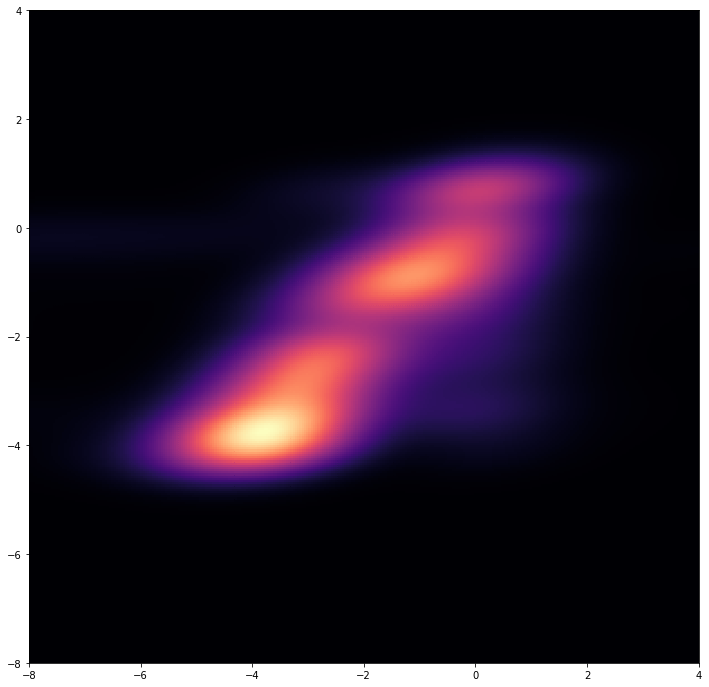

In [699]:
# Files to process and proportion of pixels to randomly sample
multibeam_paths = glob.glob("/g/data/r78/rt1527/nidem/raw_data/validation/WAMSI_KimberlyReefs/*.tif")
n_prop = 0.05

# List to save sampled elevation data
out_list = list()

# Iterate over all combinations of multibeam rasters and NIDEM polygons
for multibeam_path, polygon in itertools.product(multibeam_paths, [152, 78, 139]): 
    

    ##################
    # Multibeam data #
    ##################

    # Import multibeam data array 
    multibeam_basename = os.path.basename(multibeam_path)[:-4]
    multibeam_ds = gdal.Open(multibeam_path)
    multibeam_array = multibeam_ds.GetRasterBand(1).ReadAsArray() 
    
    # Calculate number of samples (1/100th of all multibeam pixels)
    n_samples = int(np.sum(multibeam_array != -9999) * n_prop)
    
    # Create random sample from pixels in multibeam data that are not nodata (-9999)
    multibeam_coords_x, multibeam_coords_y = SpatialTools.raster_randomsample(n_samples=n_samples, 
                                                                              input_raster=multibeam_path, 
                                                                              nodata=-9999)

    # Convert random coordinates to indices based on multibeam array and extract elevation
    multibeam_inds_x, multibeam_inds_y = SpatialTools.coords_to_indices(x_coords=multibeam_coords_x, 
                                                                        y_coords=multibeam_coords_y, 
                                                                        input_raster=multibeam_path)
    multibeam_elev = multibeam_array[multibeam_inds_y, multibeam_inds_x]

    # Temp write to file
    random_points = pd.DataFrame({'x': multibeam_coords_x, 'y': multibeam_coords_y})
    random_points.to_csv("{}_{}.csv".format(multibeam_basename, polygon))
    

    ##############
    # NIDEM data #
    ##############

    # Import NIDEM data array
    nidem_path = "output_data/dem/NIDEM_dem_{}.tif".format(polygon)
    nidem_ds = gdal.Open(nidem_path)
    nidem_array = nidem_ds.GetRasterBand(1).ReadAsArray()

    # Reproject random sample coords into EPSG:3577 to match NIDEM array
    nidem_coords_x, nidem_coords_y = transform(p1=Proj(init='EPSG:4283'), p2=Proj(init="EPSG:3577"),
                                               x=multibeam_coords_x, y=multibeam_coords_y)

    # Convert random sample coords to indices based on NIDEM array
    nidem_inds_x, nidem_inds_y = SpatialTools.coords_to_indices(x_coords=nidem_coords_x, 
                                                                y_coords=nidem_coords_y, 
                                                                input_raster=nidem_path)

    # Extract elevation data using indices; use list comprehension rather than numpy indexing for NIDEM
    # extraction because indices may not correspond correctly to this layer
    nidem_elev = [nidem_array[y, x] / 1000.0 if x < nidem_array.shape[1] and y < nidem_array.shape[0] \
                  else np.nan for (x, y) in zip(nidem_inds_x, nidem_inds_y)]
    
    
    ##################
    # Append to list #
    ##################
    
    elev_df = pd.DataFrame({'x': multibeam_coords_x, 'y': multibeam_coords_y,
                            'multibeam_elev': multibeam_elev, 'nidem_elev': nidem_elev})
    elev_df = elev_df.dropna()
    out_list.append(elev_df)  


############
# Plotting #
############

# Plot
elev_all_df = pd.concat(out_list) 
plot_kde(x_vals=elev_all_df["multibeam_elev"], y_vals=elev_all_df["nidem_elev"], 
         x_lims=(-8, 4), y_lims=(-8, 4))

# R-squared
val_nooutliers_df = elev_all_df[(np.abs(stats.zscore(elev_all_df)) < 3).all(axis=1)]
sm.ols(formula = "multibeam_elev~nidem_elev", data = val_nooutliers_df).fit().rsquared
